# Hotel Guest Sentiment Analysis - NLP Project

This notebook provides a comprehensive analysis of hotel guest reviews using Natural Language Processing (NLP) techniques.

## Project Overview
- **Data Collection and Preparation**: Clean and preprocess hotel reviews
- **Sentiment Analysis**: Classify reviews as positive, negative, or neutral
- **Visualization**: Create charts and graphs to understand sentiment distribution
- **Aspect Analysis**: Identify key aspects mentioned in reviews

## Dataset
Real-world hotel reviews dataset with 56 reviews including sentiment labels and primary aspects.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
from textblob import TextBlob
import re

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.5


## Task 1: Data Collection and Preparation

Load the dataset and perform text cleaning and preprocessing.


In [2]:
# Load the dataset
df = pd.read_csv('data/hotel_reviews_dataset.csv')

print(f"Dataset loaded successfully!")
print(f"Total reviews: {len(df)}")
print(f"\nDataset columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset loaded successfully!
Total reviews: 100

Dataset columns: ['Review ID', 'Sentiment', 'Primary Aspect', 'Cleaned Text (Lowercased)']

First few rows:


,Review ID,Sentiment,Primary Aspect,Cleaned Text (Lowercased)
0,1,Mixed,Food/Restaurant & Staff,"lunch meal was very nice. lavish, our waiter w..."
1,2,Positive,Food/Restaurant & Staff,wonderful experience at cafe resto. always wit...
2,3,Negative,Overall & Room & Staff,this so-called 5-star hotel barely feels like ...
3,4,Positive,Staff & Food/Restaurant,thank you ankit for your great service. food w...
4,5,Positive,Location & Price & Staff,location is ideal. pricing is reasonable. peop...


In [3]:
# Data cleaning and preparation function
def prepare_text(text):
    """
    Clean and prepare text for sentiment analysis
    - Convert to lowercase (already done in dataset)
    - Remove special characters
    - Remove extra whitespace
    """
    if pd.isna(text):
        return ""
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s\.\!\?]', '', text)
    
    return text.strip()

# Apply text cleaning
df['cleaned_text'] = df['Cleaned Text (Lowercased)'].apply(prepare_text)

print("Text cleaning completed!")
print(f"\nSample cleaned text:")
print(df[['Review ID', 'Cleaned Text (Lowercased)', 'cleaned_text']].head(3))


Text cleaning completed!

Sample cleaned text:
   Review ID                          Cleaned Text (Lowercased)  \
0          1  lunch meal was very nice. lavish, our waiter w...   
1          2  wonderful experience at cafe resto. always wit...   
2          3  this so-called 5-star hotel barely feels like ...   

                                        cleaned_text  
0  lunch meal was very nice. lavish our waiter wa...  
1  wonderful experience at cafe resto. always wit...  
2  this socalled 5star hotel barely feels like a ...  


In [4]:
# Check data quality
print("Dataset Information:")
print(f"Total reviews: {len(df)}")
print(f"Missing values in cleaned text: {df['cleaned_text'].isna().sum()}")
print(f"\nSentiment distribution:")
print(df['Sentiment'].value_counts())
print(f"\nPercentage distribution:")
print(df['Sentiment'].value_counts(normalize=True) * 100)


Dataset Information:
Total reviews: 100
Missing values in cleaned text: 0

Sentiment distribution:
Sentiment
Positive    49
Negative    38
Mixed       13
Name: count, dtype: int64

Percentage distribution:
Sentiment
Positive    49.0
Negative    38.0
Mixed       13.0
Name: proportion, dtype: float64


## Task 2: Sentiment Analysis

Perform sentiment analysis using TextBlob to classify reviews as positive, negative, or neutral.


In [5]:
def analyze_sentiment(text):
    """
    Analyze sentiment of a review using TextBlob
    Returns: sentiment label and polarity score
    """
    # Create TextBlob object
    blob = TextBlob(text)
    
    # Get polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    
    # Classify sentiment
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return {
        'sentiment': sentiment,
        'polarity': round(polarity, 3),
        'subjectivity': round(blob.sentiment.subjectivity, 3)
    }

# Apply sentiment analysis to all reviews
print("Performing sentiment analysis...")
results = []
for idx, row in df.iterrows():
    result = analyze_sentiment(row['cleaned_text'])
    result['review_id'] = row['Review ID']
    result['review'] = row['cleaned_text']
    results.append(result)

# Create results dataframe
results_df = pd.DataFrame(results)
df = df.merge(results_df[['review_id', 'sentiment', 'polarity', 'subjectivity']], 
              left_on='Review ID', right_on='review_id', how='left')

print("Sentiment analysis completed!")
print(f"\nPredicted sentiment distribution:")
print(df['sentiment'].value_counts())


Performing sentiment analysis...
Sentiment analysis completed!

Predicted sentiment distribution:
sentiment
positive    67
negative    31
neutral      2
Name: count, dtype: int64


In [6]:
# Compare actual vs predicted sentiment
print("=" * 60)
print("SENTIMENT ANALYSIS RESULTS")
print("=" * 60)

# Map actual sentiment to lowercase for comparison
df['actual_sentiment_lower'] = df['Sentiment'].str.lower()

# Calculate accuracy (treating 'mixed' as 'neutral')
df['actual_mapped'] = df['actual_sentiment_lower'].replace('mixed', 'neutral')
accuracy = (df['sentiment'] == df['actual_mapped']).sum() / len(df) * 100

print(f"\nModel Accuracy: {accuracy:.2f}%")
print(f"Correct predictions: {(df['sentiment'] == df['actual_mapped']).sum()}/{len(df)}")

print("\nConfusion Matrix:")
confusion = pd.crosstab(df['actual_mapped'], df['sentiment'], margins=True)
print(confusion)


SENTIMENT ANALYSIS RESULTS

Model Accuracy: 81.00%
Correct predictions: 81/100

Confusion Matrix:
sentiment      negative  neutral  positive  All
actual_mapped                                  
negative             31        1         6   38
neutral               0        1        12   13
positive              0        0        49   49
All                  31        2        67  100


In [7]:
# Display sample results
print("\nSample Analysis Results:")
print("=" * 60)
sample_df = df[['Review ID', 'Sentiment', 'sentiment', 'polarity', 'subjectivity', 'cleaned_text', 'actual_mapped']].head(10)
for idx, row in sample_df.iterrows():
    match = "MATCH" if row['sentiment'] == row['actual_mapped'] else "NO MATCH"
    print(f"\nReview {row['Review ID']}:")
    print(f"  Text: {row['cleaned_text'][:80]}...")
    print(f"  Actual: {row['Sentiment']} | Predicted: {row['sentiment']} | Match: {match}")
    print(f"  Polarity: {row['polarity']:.3f} | Subjectivity: {row['subjectivity']:.3f}")



Sample Analysis Results:

Review 1:
  Text: lunch meal was very nice. lavish our waiter was very attentive sometimes a bit t...
  Actual: Mixed | Predicted: positive | Match: NO MATCH
  Polarity: 0.556 | Subjectivity: 0.760

Review 2:
  Text: wonderful experience at cafe resto. always with mr. lavish. the experience at re...
  Actual: Positive | Predicted: positive | Match: MATCH
  Polarity: 0.625 | Subjectivity: 0.700

Review 3:
  Text: this socalled 5star hotel barely feels like a 3star. service is extremely poor. ...
  Actual: Negative | Predicted: negative | Match: MATCH
  Polarity: -0.206 | Subjectivity: 0.606

Review 4:
  Text: thank you ankit for your great service. food was really great at the restaurant....
  Actual: Positive | Predicted: positive | Match: MATCH
  Polarity: 0.587 | Subjectivity: 0.680

Review 5:
  Text: location is ideal. pricing is reasonable. people staff are good....
  Actual: Positive | Predicted: positive | Match: MATCH
  Polarity: 0.600 | Subjectivity: 

## Task 3: Visualizing Sentiment Distribution

Create visualizations to understand sentiment distribution across reviews.


Visualizations saved as 'sentiment_analysis_dashboard.png'


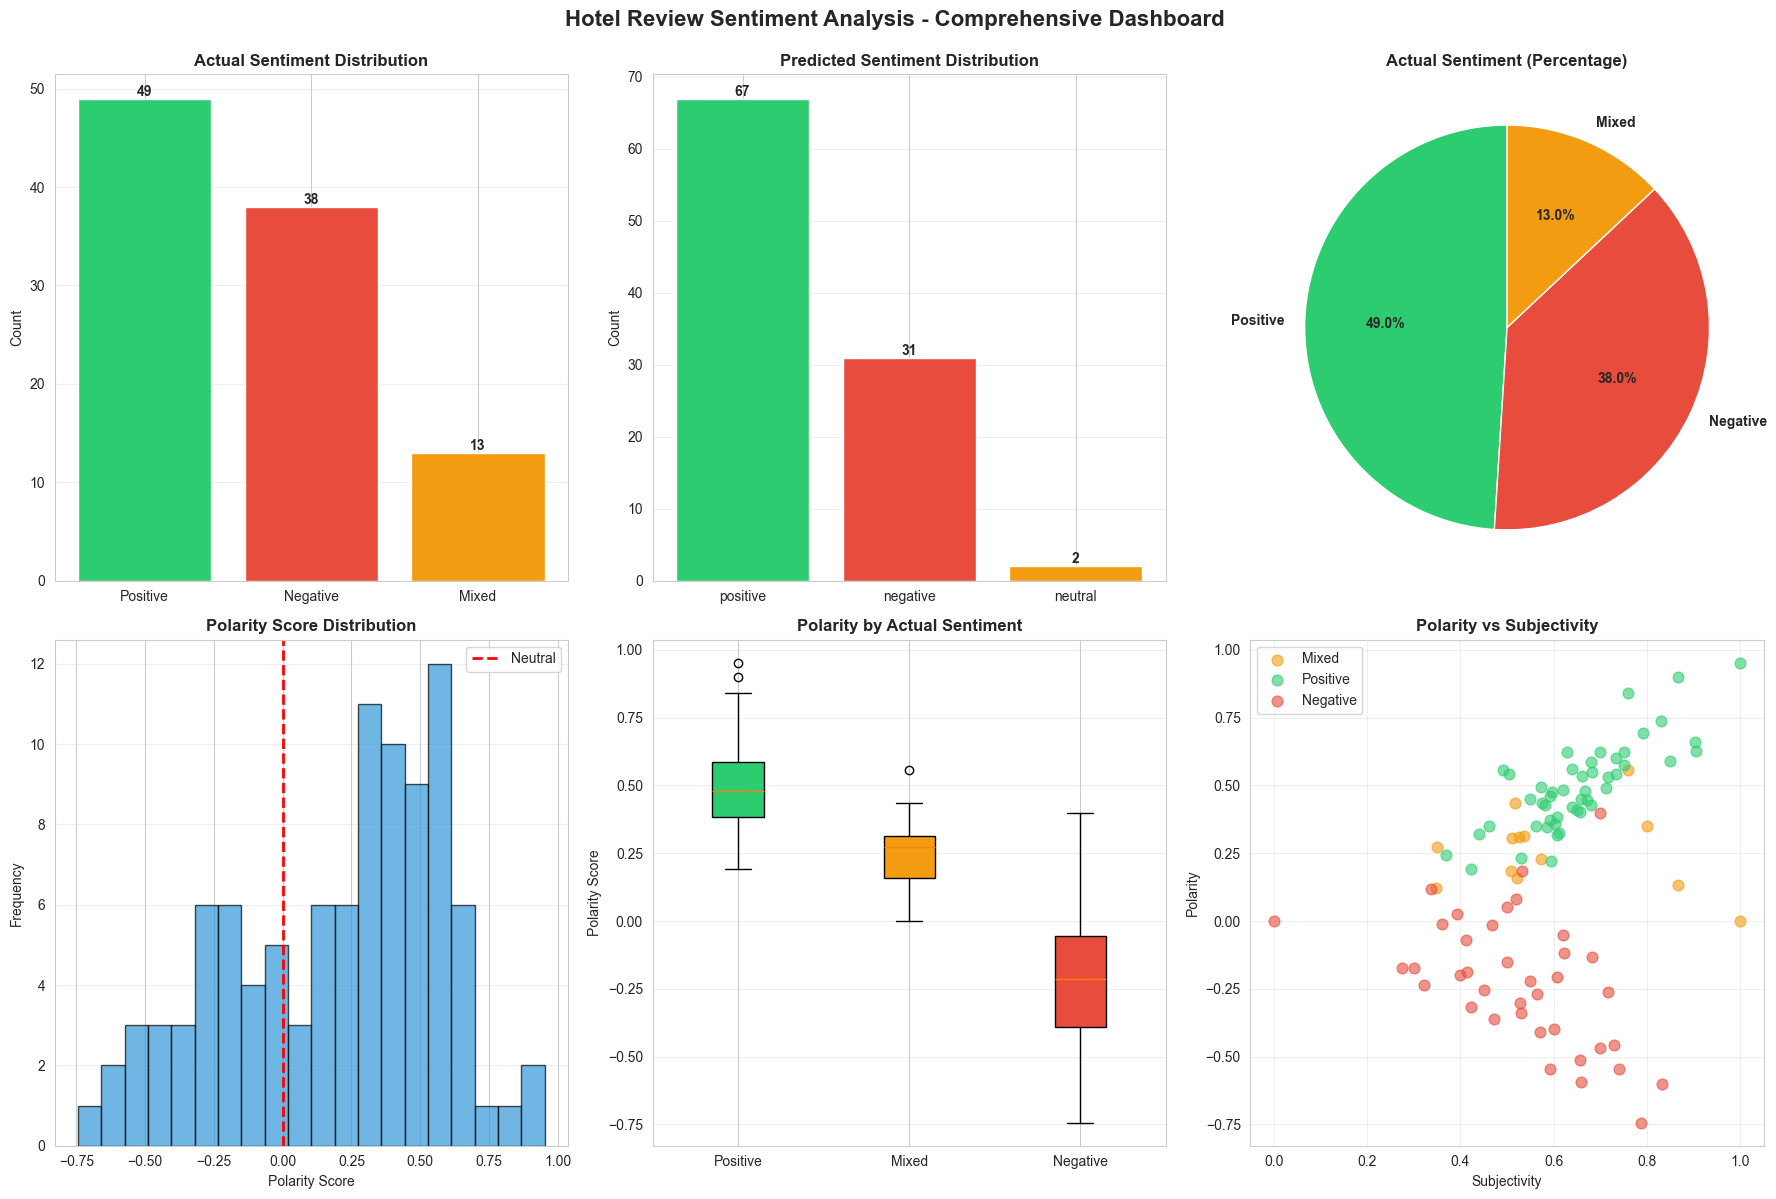

In [8]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Hotel Review Sentiment Analysis - Comprehensive Dashboard', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Actual Sentiment Distribution (Bar Chart)
ax1 = axes[0, 0]
actual_counts = df['Sentiment'].value_counts()
colors = {'Positive': '#2ecc71', 'Negative': '#e74c3c', 'Mixed': '#f39c12'}
bars1 = ax1.bar(actual_counts.index, actual_counts.values, 
                color=[colors.get(s, '#95a5a6') for s in actual_counts.index])
ax1.set_title('Actual Sentiment Distribution', fontweight='bold')
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 2. Predicted Sentiment Distribution (Bar Chart)
ax2 = axes[0, 1]
predicted_counts = df['sentiment'].value_counts()
colors_pred = {'positive': '#2ecc71', 'negative': '#e74c3c', 'neutral': '#f39c12'}
bars2 = ax2.bar(predicted_counts.index, predicted_counts.values,
                color=[colors_pred.get(s, '#95a5a6') for s in predicted_counts.index])
ax2.set_title('Predicted Sentiment Distribution', fontweight='bold')
ax2.set_ylabel('Count')
ax2.grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 3. Actual Sentiment Distribution (Pie Chart)
ax3 = axes[0, 2]
ax3.pie(actual_counts.values, labels=actual_counts.index, autopct='%1.1f%%',
        colors=[colors.get(s, '#95a5a6') for s in actual_counts.index],
        startangle=90, textprops={'fontweight': 'bold'})
ax3.set_title('Actual Sentiment (Percentage)', fontweight='bold')

# 4. Polarity Distribution Histogram
ax4 = axes[1, 0]
ax4.hist(df['polarity'], bins=20, color='#3498db', edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral')
ax4.set_title('Polarity Score Distribution', fontweight='bold')
ax4.set_xlabel('Polarity Score')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Polarity by Actual Sentiment (Box Plot)
ax5 = axes[1, 1]
sentiment_order = ['Positive', 'Mixed', 'Negative']
polarity_data = [df[df['Sentiment'] == s]['polarity'].values 
                 for s in sentiment_order if s in df['Sentiment'].values]
labels = [s for s in sentiment_order if s in df['Sentiment'].values]
bp = ax5.boxplot(polarity_data, tick_labels=labels, patch_artist=True)
for patch, label in zip(bp['boxes'], labels):
    patch.set_facecolor(colors.get(label, '#95a5a6'))
ax5.set_title('Polarity by Actual Sentiment', fontweight='bold')
ax5.set_ylabel('Polarity Score')
ax5.grid(axis='y', alpha=0.3)

# 6. Polarity vs Subjectivity Scatter
ax6 = axes[1, 2]
for sentiment in df['Sentiment'].unique():
    subset = df[df['Sentiment'] == sentiment]
    ax6.scatter(subset['subjectivity'], subset['polarity'], 
               label=sentiment, color=colors.get(sentiment, '#95a5a6'),
               alpha=0.6, s=60)
ax6.set_title('Polarity vs Subjectivity', fontweight='bold')
ax6.set_xlabel('Subjectivity')
ax6.set_ylabel('Polarity')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sentiment_analysis_dashboard.png', dpi=300, bbox_inches='tight')
print("Visualizations saved as 'sentiment_analysis_dashboard.png'")
plt.show()


## Aspect Analysis

Analyze the primary aspects mentioned in reviews and their sentiment distribution.


In [9]:
# Extract and analyze aspects
from collections import Counter

def extract_aspects(aspect_string):
    """Extract individual aspects from the Primary Aspect column"""
    if pd.isna(aspect_string):
        return []
    aspects = [a.strip() for a in str(aspect_string).split('&')]
    return aspects

# Extract all aspects
all_aspects = []
for aspect_str in df['Primary Aspect'].dropna():
    aspects = extract_aspects(aspect_str)
    all_aspects.extend(aspects)

aspect_counts = Counter(all_aspects)

print("Top 10 Most Mentioned Aspects:")
print("=" * 60)
for aspect, count in aspect_counts.most_common(10):
    print(f"{aspect:30s}: {count:3d} times")


Top 10 Most Mentioned Aspects:
Room                          :  57 times
Staff                         :  55 times
Overall                       :  34 times
Facilities                    :  29 times
Service                       :  26 times
Location                      :  22 times
Cleanliness                   :  15 times
Food/Restaurant               :  14 times
Value                         :   7 times
Food                          :   7 times


Aspect analysis visualization saved as 'aspect_analysis.png'


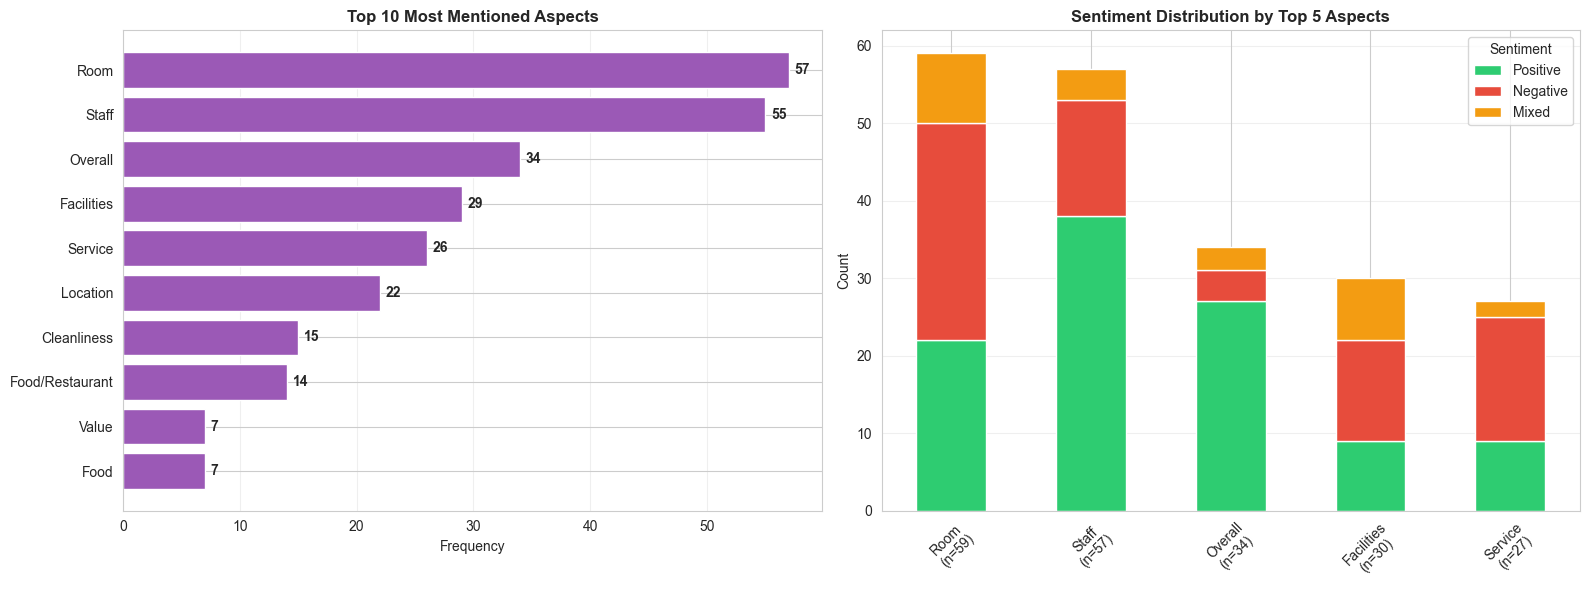

In [10]:
# Visualize top aspects
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 Aspects Bar Chart
ax1 = axes[0]
top_10_aspects = dict(aspect_counts.most_common(10))
ax1.barh(range(len(top_10_aspects)), list(top_10_aspects.values()), color='#9b59b6')
ax1.set_yticks(range(len(top_10_aspects)))
ax1.set_yticklabels(list(top_10_aspects.keys()))
ax1.set_title('Top 10 Most Mentioned Aspects', fontweight='bold', fontsize=12)
ax1.set_xlabel('Frequency')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
for i, (aspect, count) in enumerate(top_10_aspects.items()):
    ax1.text(count + 0.5, i, str(count), va='center', fontweight='bold')

# Sentiment Distribution by Top 5 Aspects
ax2 = axes[1]
top_5_aspects = [a[0] for a in aspect_counts.most_common(5)]
aspect_sentiment_data = []
aspect_labels = []

for aspect in top_5_aspects:
    aspect_reviews = df[df['Primary Aspect'].str.contains(aspect, case=False, na=False)]
    if len(aspect_reviews) > 0:
        sentiment_dist = aspect_reviews['Sentiment'].value_counts()
        aspect_labels.append(f"{aspect}\n(n={len(aspect_reviews)})")
        aspect_sentiment_data.append([
            sentiment_dist.get('Positive', 0),
            sentiment_dist.get('Negative', 0),
            sentiment_dist.get('Mixed', 0)
        ])

if aspect_sentiment_data:
    aspect_sentiment_df = pd.DataFrame(aspect_sentiment_data, 
                                       index=aspect_labels,
                                       columns=['Positive', 'Negative', 'Mixed'])
    aspect_sentiment_df.plot(kind='bar', stacked=True, ax=ax2, 
                            color=['#2ecc71', '#e74c3c', '#f39c12'])
    ax2.set_title('Sentiment Distribution by Top 5 Aspects', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Count')
    ax2.legend(title='Sentiment')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('aspect_analysis.png', dpi=300, bbox_inches='tight')
print("Aspect analysis visualization saved as 'aspect_analysis.png'")
plt.show()


## Summary Statistics

Generate comprehensive statistics and save results.


In [11]:
# Generate summary statistics
print("=" * 80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)

print(f"\nDataset Overview:")
print(f"  Total Reviews: {len(df)}")
print(f"  Average Review Length: {df['cleaned_text'].str.len().mean():.1f} characters")

print(f"\nSentiment Distribution (Actual):")
for sentiment, count in df['Sentiment'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  {sentiment:10s}: {count:3d} reviews ({percentage:5.2f}%)")

print(f"\nModel Performance:")
print(f"  Accuracy: {accuracy:.2f}%")
print(f"  Correct Predictions: {(df['sentiment'] == df['actual_mapped']).sum()}/{len(df)}")

print(f"\nPolarity Statistics:")
print(f"  Average Polarity: {df['polarity'].mean():.3f}")
print(f"  Median Polarity: {df['polarity'].median():.3f}")
print(f"  Min Polarity: {df['polarity'].min():.3f}")
print(f"  Max Polarity: {df['polarity'].max():.3f}")
print(f"  Standard Deviation: {df['polarity'].std():.3f}")

print(f"\nPolarity by Sentiment:")
for sentiment in df['Sentiment'].unique():
    subset = df[df['Sentiment'] == sentiment]
    print(f"  {sentiment:10s}: {subset['polarity'].mean():.3f} (avg)")

print(f"\nAspect Analysis:")
print(f"  Total Unique Aspects: {len(aspect_counts)}")
print(f"  Most Common Aspect: {aspect_counts.most_common(1)[0][0]} ({aspect_counts.most_common(1)[0][1]} mentions)")

print("\n" + "=" * 80)


COMPREHENSIVE ANALYSIS SUMMARY

Dataset Overview:
  Total Reviews: 100
  Average Review Length: 176.6 characters

Sentiment Distribution (Actual):
  Positive  :  49 reviews (49.00%)
  Negative  :  38 reviews (38.00%)
  Mixed     :  13 reviews (13.00%)

Model Performance:
  Accuracy: 81.00%
  Correct Predictions: 81/100

Polarity Statistics:
  Average Polarity: 0.191
  Median Polarity: 0.312
  Min Polarity: -0.744
  Max Polarity: 0.953
  Standard Deviation: 0.387

Polarity by Sentiment:
  Mixed     : 0.259 (avg)
  Positive  : 0.495 (avg)
  Negative  : -0.223 (avg)

Aspect Analysis:
  Total Unique Aspects: 32
  Most Common Aspect: Room (57 mentions)



In [12]:
# Save results to CSV
output_df = df[['Review ID', 'Sentiment', 'Primary Aspect', 'cleaned_text', 
                'sentiment', 'polarity', 'subjectivity']].copy()
output_df.columns = ['Review_ID', 'Actual_Sentiment', 'Primary_Aspect', 'Review_Text',
                    'Predicted_Sentiment', 'Polarity', 'Subjectivity']
output_df.to_csv('sentiment_analysis_results.csv', index=False)

print("[SUCCESS] Results saved to 'sentiment_analysis_results.csv'")
print("\nGenerated Files:")
print("  - sentiment_analysis_dashboard.png")
print("  - aspect_analysis.png")
print("  - sentiment_analysis_results.csv")
print("\nAnalysis Complete!")


[SUCCESS] Results saved to 'sentiment_analysis_results.csv'

Generated Files:
  - sentiment_analysis_dashboard.png
  - aspect_analysis.png
  - sentiment_analysis_results.csv

Analysis Complete!
